# Overview
Rather than trying to segment, we start off by making a model that simply tries to identify if any boat shows up in the image. For this model we can see roughly how it performs in the compititon by guessing the whole image (as an RLE) if any boat shows up (not a very smart startegy, but might provide some interesting results).

Beyond
The model could also be useful as a quick way (low resolution images) to screen through lots of images to see if they are likely to have a boat and if they are then run a much more expensive full-resolution U-Net on that sample

Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations). It is slightly easier to keep track of parallel notebooks with different parameters if they are all at the beginning in a clear (machine readable format, see Kaggling with Kaggle (https://www.kaggle.com/kmader/kaggling-with-kaggle). 

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

Using TensorFlow backend.


In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage
path = "/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship Detection Challenge/"


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


masks = pd.read_csv(os.path.join(path + 'train_ship_segmentations_v2.csv'))

print(masks.shape[0],'masks found')

masks.head()

231723 masks found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# number of validation images to use
VALID_IMG_COUNT = 1000
# maximum number of training images
MAX_TRAIN_IMAGES = 15000 
BASE_MODEL='DenseNet169' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (299, 299) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 128
LEARN_RATE = 1e-4
RGB_FLIP = 1 # should rgb be flipped when rendering images

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = path
train_image_dir = os.path.join(path, 'train_v2')
test_image_dir = os.path.join(path, 'test_v2')
import gc; gc.enable() # memory is tight

In [4]:
masks['path'] = masks['ImageId'].map(lambda x: os.path.join(train_image_dir, x))
masks.head()

,ImageId,EncodedPixels,path
0,00003e153.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...
1,0001124c7.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...


# Split into training and validation groups¶
We stratify by the number of boats appearing so we have nice balances in each set

In [5]:
from sklearn.model_selection import train_test_split
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

162201 training masks
69522 validation masks


# Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

In [6]:
print(MAX_TRAIN_IMAGES,train_df.shape)

15000 (162201, 6)


In [7]:
train_df = train_df.sample(min(MAX_TRAIN_IMAGES, train_df.shape[0])) # limit size of training set (otherwise it takes too long)

In [8]:
train_df

,ImageId,EncodedPixels,path,ships,has_ship,has_ship_vec
39458,3e73dc08d.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,0,0.0,[0.0]
48497,4cb67f9bf.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,0,0.0,[0.0]
31215,3183fe988.jpg,448078 1 448844 4 449610 6 450377 8 451143 10 ...,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,5,1.0,[1.0]
77613,7a310295a.jpg,290920 1 291687 3 292453 5 293220 7 293987 9 2...,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,8,1.0,[1.0]
122152,c099dfb65.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,0,0.0,[0.0]
...,...,...,...,...,...,...
115697,b63595563.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,0,0.0,[0.0]
71265,706cb7d96.jpg,87617 1 88384 4 89151 6 89919 8 90686 10 91453...,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,9,1.0,[1.0]
4534,07205f6ed.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,0,0.0,[0.0]
98112,9aacf5ecd.jpg,NaN,/mnt/3CE35B99003D727B/input/kaggle/Airbus Ship...,0,0.0,[0.0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43142d9d68>,
      dtype=object)

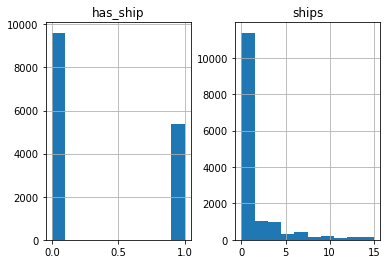

In [9]:
train_df[['ships','has_ship']].hist()

# Augmentet Data

In [10]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

Using TensorFlow backend.
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorboard/

In [11]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.5, 1.5],
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)
valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

In [12]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [13]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 15000 images


In [14]:
# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 69522 images


IndexError: list index out of range